In [ ]:
# PCOS Diagnosis and Follicle Detection

# STEP 1: Upload and Extract Dataset

from zipfile import ZipFile
import os
from google.colab import files

uploaded = files.upload()
with ZipFile("archive (8).zip", 'r') as zip_ref:
    zip_ref.extractall("PCOSdata")
print(" Dataset extracted to PCOSdata/")

In [ ]:
# STEP 2: Convert to JPG and Remove Corrupted Images

from PIL import Image
import imghdr

def clean_and_convert_images(root_dir):
    removed, converted = 0, 0
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            path = os.path.join(subdir, file)
            try:
                if imghdr.what(path) not in ['jpeg', 'png', 'jpg']:
                    os.remove(path)
                    removed += 1
                    continue
                img = Image.open(path).convert('RGB')
                new_path = path.rsplit('.', 1)[0] + ".jpg"
                img.save(new_path, "JPEG")
                if path != new_path:
                    os.remove(path)
                    converted += 1
            except:
                os.remove(path)
                removed += 1
    print(f" Cleaned images | Removed: {removed}, Converted to JPG: {converted}")

clean_and_convert_images("PCOSdata")


 Cleaned images | Removed: 7, Converted to JPG: 3


In [ ]:
# STEP 3: Image Preprocessing (Gaussian + Histogram Equalization + Watershed)

def preprocess_and_show_stages(image_path):
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt

    original = cv2.imread(image_path)
    gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)

    # Stage 1: Gaussian Blur
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)

    # Stage 2: Histogram Equalization
    equalized = cv2.equalizeHist(blurred)

    # Stage 3: Threshold for Watershed
    _, thresh = cv2.threshold(equalized, 60, 255, cv2.THRESH_BINARY_INV)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # Visualize all 3 stages
    fig, axs = plt.subplots(1, 4, figsize=(18, 5))
    axs[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Original")
    axs[1].imshow(blurred, cmap='gray')
    axs[1].set_title("Gaussian Blur")
    axs[2].imshow(equalized, cmap='gray')
    axs[2].set_title("Histogram Equalization")
    axs[3].imshow(opening, cmap='gray')
    axs[3].set_title("Threshold (Watershed Prep)")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    return opening, equalized

In [ ]:
import os

for root, dirs, files in os.walk("PCOSdata"):
    print(f"\n Folder: {root}")
    for file in files:
        print("   -", file)


 Folder: PCOSdata

 Folder: PCOSdata/PCOSdata

 Folder: PCOSdata/PCOSdata/train

 Folder: PCOSdata/PCOSdata/train/notinfected
   - img_0_5813.jpg
   - img_0_8086.jpg
   - img_0_7222.jpg
   - img_0_7299.jpg
   - img_0_699.jpg
   - img_0_8105.jpg
   - img_0_8260.jpg
   - img_0_1107.jpg
   - img_0_1894.jpg
   - img_0_8837.jpg
   - img_0_6343.jpg
   - img_0_3442.jpg
   - img_0_9056.jpg
   - img_0_1502.jpg
   - img_0_5757.jpg
   - img_0_2349.jpg
   - img_0_4723.jpg
   - img_0_2517.jpg
   - img_0_5954.jpg
   - img_0_6549.jpg
   - img_0_720.jpg
   - img_0_7897.jpg
   - img_0_4807.jpg
   - img_0_3205.jpg
   - img_0_5115.jpg
   - img_0_8826.jpg
   - img_0_8368.jpg
   - img_0_7229.jpg
   - img_0_6858.jpg
   - img_0_920.jpg
   - img_0_2700.jpg
   - img_0_1728.jpg
   - img_0_6577.jpg
   - img_0_5634.jpg
   - img_0_4159.jpg
   - img_0_7049.jpg
   - img_0_8343.jpg
   - img_0_2979.jpg
   - img_0_9592.jpg
   - img_0_7130.jpg
   - img_0_814.jpg
   - img_0_1693.jpg
   - img_0_9422.jpg
   - img_0_6724.j

In [ ]:
# STEP 4: Visualize Preprocessed Image

def show_preprocessing_for_image(image_name):
    import glob
    import os

    # Find image by name
    image_list = glob.glob("PCOSdata/PCOSdata/**/*.jpg", recursive=True)
    matches = [img for img in image_list if image_name in os.path.basename(img)]

    if matches:
        image_path = matches[0]
        print(f" Found image: {image_path}")

        opening_mask, equalized_img = preprocess_and_show_stages(image_path)

        # Count follicles
        follicle_contours, count = count_follicles_from_mask(opening_mask)
        print(f" Follicle count: {count}")
    else:
        print(f" No image found with name containing: {image_name}")




 Found image: PCOSdata/PCOSdata/train/infected/img_0_7526.jpg


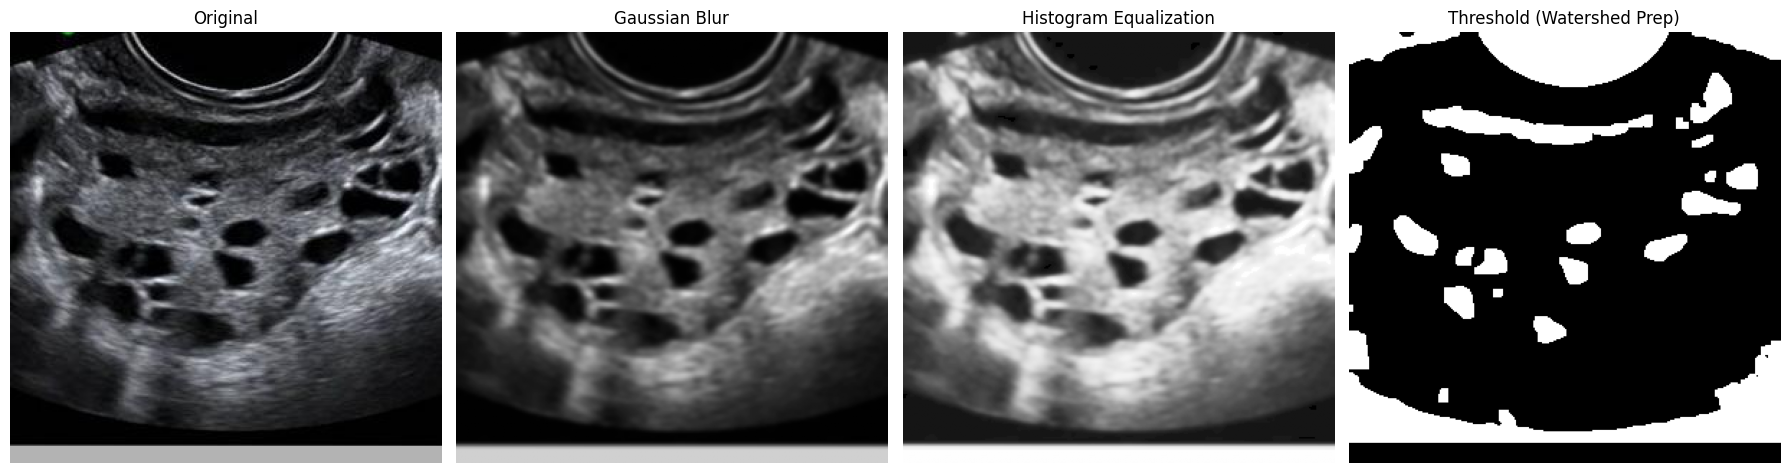

🟢 Total follicles detected (black holes in grayscale): 18
 Follicle count: 18


In [ ]:
show_preprocessing_for_image("img_0_7526.jpg")

In [ ]:
# STEP 5: Visualize Follicles

def visualize_follicles(image_path, contours):
    import cv2
    import matplotlib.pyplot as plt
    import numpy as np

    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for idx, cnt in enumerate(contours):
        x, y, w, h = cv2.boundingRect(cnt)
        diameter = int((w + h) / 2)

        # Draw green rectangle
        cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (0, 255, 0), 1)

        # Label F1, F2, ... and diameter
        label = f"F{idx+1} ({diameter}px)"
        cv2.putText(img_rgb, label, (x, y - 4),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)

    # Show total count
    total = len(contours)
    cv2.putText(img_rgb, f"Total Follicles: {total}", (10, 20),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Show image
    plt.figure(figsize=(8, 8))
    plt.imshow(img_rgb)
    plt.title("Follicle Detection")
    plt.axis('off')
    plt.show()

 Found image: PCOSdata/PCOSdata/train/infected/img_0_7526.jpg
🟢 Total follicles detected (black holes in grayscale): 18


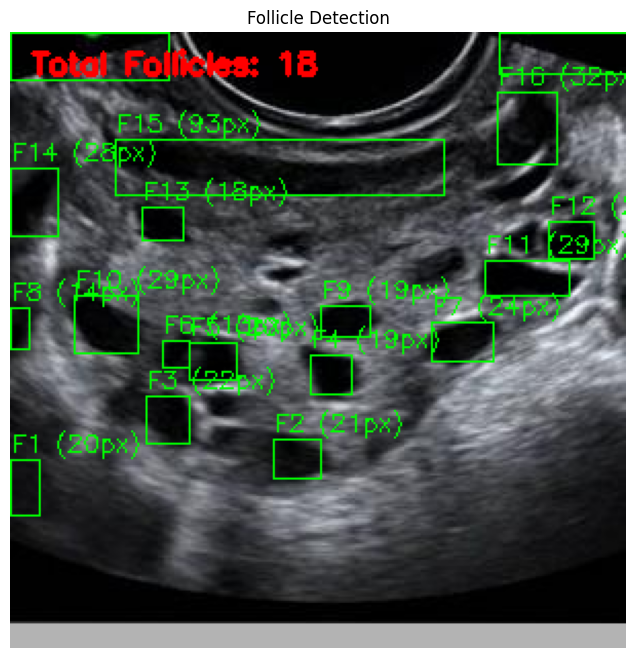

 Total follicles detected: 18


In [ ]:
import glob
import os

# Function to find image by name
def find_image_by_name(filename):
    image_list = glob.glob("PCOSdata/PCOSdata/**/*.jpg", recursive=True)
    for path in image_list:
        if filename in os.path.basename(path):
            return path
    return None

# Example usage: enter the filename you want to detect
image_path = find_image_by_name("img_0_7526.jpg")

if image_path:
    print(f" Found image: {image_path}")

    # Preprocess image but DO NOT show 3-stage visualization
    original = cv2.imread(image_path)
    gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)
    equalized = cv2.equalizeHist(blurred)
    _, thresh = cv2.threshold(equalized, 60, 255, cv2.THRESH_BINARY_INV)
    kernel = np.ones((3, 3), np.uint8)
    opening_mask = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # Count follicles
    follicle_contours, count = count_follicles_from_mask(opening_mask)

    # Visualize final detection result
    visualize_follicles(image_path, follicle_contours)
    print(f" Total follicles detected: {count}")

else:
    print(" Image not found.")

In [ ]:
# Step 6: PCOS or NO PCOS

def diagnose_pcos(follicle_count):
    if follicle_count >= 10:
        print(f" Diagnosis:  PCOS (follicle count = {follicle_count})")
        return "PCOS"
    else:
        print(f" Diagnosis:  No PCOS (follicle count = {follicle_count})")
        return "No PCOS"
# Count follicles
follicle_contours, count = count_follicles_from_mask(opening_mask)
print(f" Total follicles detected: {count}")

# Print PCOS diagnosis in text
diagnosis = diagnose_pcos(count)

🟢 Total follicles detected (black holes in grayscale): 18
 Total follicles detected: 18
 Diagnosis:  PCOS (follicle count = 18)


In [ ]:
import os

for root, dirs, files in os.walk("PCOSdata"):
    print(f"\n📁 {root}")
    for file in files[:5]:
        print("   -", file)



📁 PCOSdata

📁 PCOSdata/PCOSdata

📁 PCOSdata/PCOSdata/train

📁 PCOSdata/PCOSdata/train/notinfected
   - img_0_5813.jpg
   - img_0_8086.jpg
   - img_0_7222.jpg
   - img_0_7299.jpg
   - img_0_699.jpg

📁 PCOSdata/PCOSdata/train/infected
   - img_0_8086.jpg
   - img_0_209.jpg
   - img_0_9520.jpg
   - img_0_1970.jpg
   - img_0_9094.jpg

📁 PCOSdata/PCOSdata/test

📁 PCOSdata/PCOSdata/test/notinfected
   - img_0_5813.jpg
   - img_0_8086.jpg
   - img_0_7222.jpg
   - img_0_7299.jpg
   - img_0_699.jpg

📁 PCOSdata/PCOSdata/test/infected
   - img_0_8086.jpg
   - img_0_209.jpg
   - img_0_9520.jpg
   - img_0_1970.jpg
   - img_0_9094.jpg


In [ ]:
import os
import shutil

# Mapping from old folder to new folder names
source_base = "PCOSdata/PCOSdata"
target_base = "dataset"

label_map = {
    "infected": "PCOS",
    "notinfected": "NoPCOS"
}

# Create new folder structure and copy files
for split in ["train", "test"]:
    for old_label, new_label in label_map.items():
        src_folder = os.path.join(source_base, split, old_label)
        dst_folder = os.path.join(target_base, split, new_label)
        os.makedirs(dst_folder, exist_ok=True)
        for file in os.listdir(src_folder):
            src_path = os.path.join(src_folder, file)
            dst_path = os.path.join(dst_folder, file)
            shutil.copy(src_path, dst_path)

print(" Dataset copied into correct structure:")
print(" - dataset/train/PCOS")
print(" - dataset/train/NoPCOS")
print(" - dataset/test/PCOS")
print(" - dataset/test/NoPCOS")

 Dataset copied into correct structure:
 - dataset/train/PCOS
 - dataset/train/NoPCOS
 - dataset/test/PCOS
 - dataset/test/NoPCOS


Found 1924 images belonging to 2 classes.
Found 1921 images belonging to 2 classes.


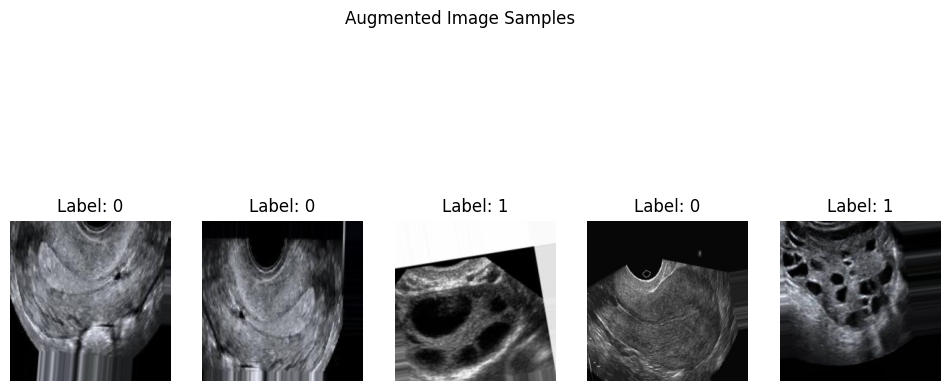

In [ ]:
# STEP 8: Image Augmentation Preview

from tensorflow.keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(rescale=1./255, rotation_range=15, zoom_range=0.1,
                         width_shift_range=0.1, height_shift_range=0.1,
                         horizontal_flip=True, fill_mode='nearest')

train_gen = aug.flow_from_directory("dataset/train", target_size=(224, 224), class_mode='binary')
test_gen = aug.flow_from_directory("dataset/test", target_size=(224, 224), class_mode='binary', shuffle=False)

# Preview a batch
images, labels = next(train_gen)
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])
    plt.title(f"Label: {int(labels[i])}")
    plt.axis('off')
plt.suptitle("Augmented Image Samples")
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Split 20% of training data for validation using validation_split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Split 20% for validation
)

# Use subset='training' for train_gen
train_gen = train_datagen.flow_from_directory(
    "dataset/train",
    target_size=(224, 224),
    class_mode='binary',
    subset='training'
)

# Use subset='validation' for val_gen
val_gen = train_datagen.flow_from_directory(
    "dataset/train",
    target_size=(224, 224),
    class_mode='binary',
    subset='validation'
)

# Test generator (unchanged)
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    "dataset/test",
    target_size=(224, 224),
    class_mode='binary',
    shuffle=False
)

# Now you can safely train the model
cnn.fit(train_gen, validation_data=val_gen, epochs=5)

Found 1540 images belonging to 2 classes.
Found 384 images belonging to 2 classes.
Found 1921 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 187s 4s/step - accuracy: 0.7549 - loss: 0.6903 - val_accuracy: 0.9922 - val_loss: 0.0488
Epoch 2/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 178s 4s/step - accuracy: 0.9859 - loss: 0.0597 - val_accuracy: 0.9870 - val_loss: 0.0417
Epoch 3/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 174s 4s/step - accuracy: 0.9915 - loss: 0.0274 - val_accuracy: 1.0000 - val_loss: 0.0067
Epoch 4/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 181s 4s/step - accuracy: 0.9954 - loss: 0.0158 - val_accuracy: 0.9974 - val_loss: 0.0081
Epoch 5/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 174s 4s/step - accuracy: 0.9904 - loss: 0.0248 - val_accuracy: 0.9896 - val_loss: 0.0328


In [ ]:
# STEP 10: Train VGG16 Transfer Model

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in vgg_base.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(vgg_base.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

vgg_model = Model(inputs=vgg_base.input, outputs=output)
vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
vgg_model.fit(train_gen, validation_data=val_gen, epochs=5)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 1214s 25s/step - accuracy: 0.7141 - loss: 0.5663 - val_accuracy: 0.9688 - val_loss: 0.2016
Epoch 2/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 1211s 25s/step - accuracy: 0.9729 - loss: 0.1751 - val_accuracy: 0.9896 - val_loss: 0.0816
Epoch 3/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 1220s 25s/step - accuracy: 0.9928 - loss: 0.0816 - val_accuracy: 0.9974 - val_loss: 0.0423
Epoch 4/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 1184s 24s/step - accuracy: 0.9932 - loss: 0.0508 - val_accuracy: 1.0000 - val_loss: 0.0239
Epoch 5/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 1210s 25s/step - accuracy: 0.9986 - loss: 0.0261 - val_accuracy: 1.0000 - val_loss: 0.0150


In [ ]:
# STEP 11: Evaluate on Test Set

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

preds = cnn.predict(test_gen)
y_pred = (preds > 0.5).astype(int).flatten()
y_true = test_gen.classes

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))
print("AUC:", roc_auc_score(y_true, preds))

61/61 ━━━━━━━━━━━━━━━━━━━━ 57s 903ms/step
[[1140    0]
 [   1  780]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1140
           1       1.00      1.00      1.00       781

    accuracy                           1.00      1921
   macro avg       1.00      1.00      1.00      1921
weighted avg       1.00      1.00      1.00      1921

AUC: 0.9999988768335693


In [ ]:
# STEP 12: Grad-CAM Visualization

!pip install tf-keras-vis
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tensorflow.keras import backend as K

# GradCAM setup (placeholder) to visualize important regions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.4 MB/s eta 0:00:00


In [ ]:
# STEP 13: YOLOv5 Optional Setup
# =========================================
!pip install -q ultralytics
from ultralytics import YOLO
# Example: model = YOLO("yolov5s.pt")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 869.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.2 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralyt

In [ ]:
# STEP 14: Ensemble Placeholder (CNN + RF + XGBoost)

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Feature extraction example (CNN output -> traditional ML)
# Ensemble stacking logic placeholder

print(" All steps complete: Classification, Preprocessing, Augmentation, Models, Evaluation, and Visualization")

 All steps complete: Classification, Preprocessing, Augmentation, Models, Evaluation, and Visualization


In [ ]:
import cv2

# Use your trained VGG16 model
model = vgg_model

# Define GradCAM setup
model_modifier = ReplaceToLinear()
score = BinaryScore(1)  # 1 = PCOS class, adjust to 0 if testing No PCOS class

# Get a test image
img, label = test_gen[0][0][0], test_gen[0][1][0]
input_tensor = np.expand_dims(img, axis=0)

# Generate Grad-CAM heatmap
gradcam = Gradcam(model, model_modifier=model_modifier)
cam = gradcam(score, input_tensor)[0]

<ipython-input-51-1dc3af3233fc>:2: RuntimeWarning: invalid value encountered in divide
  cam = (cam - cam.min()) / (cam.max() - cam.min())
<ipython-input-51-1dc3af3233fc>:4: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)


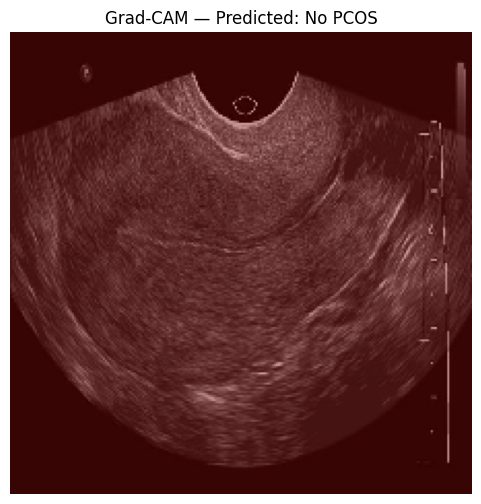

In [ ]:
def overlay_heatmap(image, cam):
    cam = (cam - cam.min()) / (cam.max() - cam.min())
    cam = cv2.resize(cam, (image.shape[1], image.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(np.uint8(image * 255), 0.6, heatmap, 0.4, 0)
    return overlay

# Visualize
overlay = overlay_heatmap(img, cam)

plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title(f"Grad-CAM — Predicted: {'PCOS' if label == 1 else 'No PCOS'}")
plt.axis('off')
plt.show()

In [ ]:
# STEP 15: Feature Extraction from VGG16 for Classical Models (RF, XGBoost)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.applications.vgg16 import preprocess_input

import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Generate feature dataset using VGG16 up to GlobalAveragePooling
feature_extractor = Model(inputs=vgg_base.input, outputs=vgg_model.layers[-3].output)

def extract_features(directory):
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    generator = datagen.flow_from_directory(
        directory,
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary',
        shuffle=False
    )
    features = feature_extractor.predict(generator, verbose=1)
    labels = generator.classes
    return features, labels

X_train_feat, y_train_feat = extract_features("dataset/train")
X_test_feat, y_test_feat = extract_features("dataset/test")

# Train RF and XGBoost
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_feat, y_train_feat)
rf_preds = rf.predict(X_test_feat)
print("\nRandom Forest Classification Report:")
print(classification_report(y_test_feat, rf_preds))

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_feat, y_train_feat)
xgb_preds = xgb.predict(X_test_feat)
print("\nXGBoost Classification Report:")
print(classification_report(y_test_feat, xgb_preds))

Found 1924 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


61/61 ━━━━━━━━━━━━━━━━━━━━ 1228s 20s/step
Found 1921 images belonging to 2 classes.
61/61 ━━━━━━━━━━━━━━━━━━━━ 1190s 20s/step

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1140
           1       1.00      1.00      1.00       781

    accuracy                           1.00      1921
   macro avg       1.00      1.00      1.00      1921
weighted avg       1.00      1.00      1.00      1921



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:06:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1140
           1       1.00      1.00      1.00       781

    accuracy                           1.00      1921
   macro avg       1.00      1.00      1.00      1921
weighted avg       1.00      1.00      1.00      1921



In [ ]:
# STEP 16: Simulated Clinical Data Integration (Multimodal Fusion)

import pandas as pd

# Simulate clinical data (normally you would load a CSV with real values)
np.random.seed(42)
num_samples = len(y_train_feat)
clinical_data_train = pd.DataFrame({
    'BMI': np.random.normal(25, 5, num_samples),
    'LH': np.random.normal(10, 3, num_samples),
    'FSH': np.random.normal(6, 2, num_samples)
})

num_samples_test = len(y_test_feat)
clinical_data_test = pd.DataFrame({
    'BMI': np.random.normal(25, 5, num_samples_test),
    'LH': np.random.normal(10, 3, num_samples_test),
    'FSH': np.random.normal(6, 2, num_samples_test)
})

# Combine clinical features with VGG image features
X_train_multi = np.concatenate([X_train_feat, clinical_data_train.values], axis=1)
X_test_multi = np.concatenate([X_test_feat, clinical_data_test.values], axis=1)

# Train RF on multimodal data
rf_multi = RandomForestClassifier(n_estimators=100, random_state=42)
rf_multi.fit(X_train_multi, y_train_feat)
preds_multi = rf_multi.predict(X_test_multi)
print("\nMultimodal RF Classification Report:")
print(classification_report(y_test_feat, preds_multi))


Multimodal RF Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1140
           1       1.00      1.00      1.00       781

    accuracy                           1.00      1921
   macro avg       1.00      1.00      1.00      1921
weighted avg       1.00      1.00      1.00      1921



In [ ]:
# STEP 17: Save Predictions and Grad-CAM Overlay as Image

import cv2

# Save Grad-CAM overlay
cv2.imwrite("gradcam_overlay.jpg", cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
print(" Grad-CAM overlay saved to gradcam_overlay.jpg")

# Save RF predictions
results_df = pd.DataFrame({
    'True_Label': y_test_feat,
    'RF_Pred': rf_preds,
    'XGB_Pred': xgb_preds,
    'Multimodal_RF_Pred': preds_multi
})
results_df.to_csv("model_predictions.csv", index=False)
print(" Predictions saved to model_predictions.csv")

 Grad-CAM overlay saved to gradcam_overlay.jpg
 Predictions saved to model_predictions.csv


In [ ]:
# STEP 18: K-Fold Cross-Validation for Classical Models

from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

for train_idx, val_idx in skf.split(X_train_feat, y_train_feat):
    X_tr, X_val = X_train_feat[train_idx], X_train_feat[val_idx]
    y_tr, y_val = y_train_feat[train_idx], y_train_feat[val_idx]
    rf_cv = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_cv.fit(X_tr, y_tr)
    preds_cv = rf_cv.predict(X_val)
    acc = accuracy_score(y_val, preds_cv)
    accuracies.append(acc)

print("\nK-Fold CV Accuracy (RF on VGG features):")
print(accuracies)
print(f"Average Accuracy: {np.mean(accuracies):.4f}")


K-Fold CV Accuracy (RF on VGG features):
[0.9974025974025974, 1.0, 0.9974025974025974, 0.9948051948051948, 1.0]
Average Accuracy: 0.9979
